100%|██████████| 2/2 [00:21<00:00, 10.76s/it]


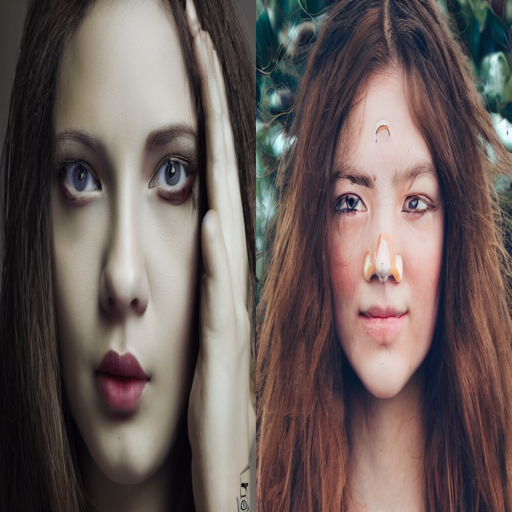

In [2]:
# !pip install ftfy 
# !pip install transformers diffusers==0.2.4 # For now specific version needed as update broke something
%reload_ext autoreload
%autoreload 2

# %run wrapper.py

from tqdm import tqdm 
import torch
from wrapper import StableDifussionWrapper, image_grid
self = StableDifussionWrapper(scheduler_type = "ddim")


# Warning: This wrapper does not have a safety filter nor adds watermark to images. Be ethical!

prompt = "face portrait, photography, full face"
self.set_scheduler(scheduler_type="ldm")
all_imgs = self.generate_images(prompt,
                        n = 2,
                        seed=2, 
                        num_inference_steps=50, 
                        guidance_scale=3)
grid = image_grid(all_imgs, rows=1, cols=2)
# grid.save("bahai-day.png")
grid.resize((512,512))

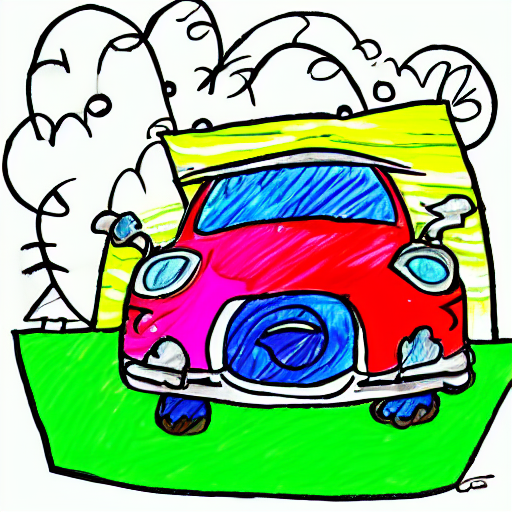

In [3]:
prompt = "a car, poorly draw by a child, colorfull"

zT = self.random_latents(seed = 87)

z0 = self.diffusion_loop(
        prompt=prompt,
        latents=zT,
        start_step=0,
        seed=None,
        num_inference_steps=20,
        guidance_scale=7.5)
x0 = self.decode(z0)
image_grid(x0)

In [11]:
with torch.no_grad():
    latent_dists = self.vae.encode(x0)
    latent_samples = latent_dists.sample()
    latent_samples *= 0.18215

tensor([14.6147, 10.7469,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000], dtype=torch.float64)

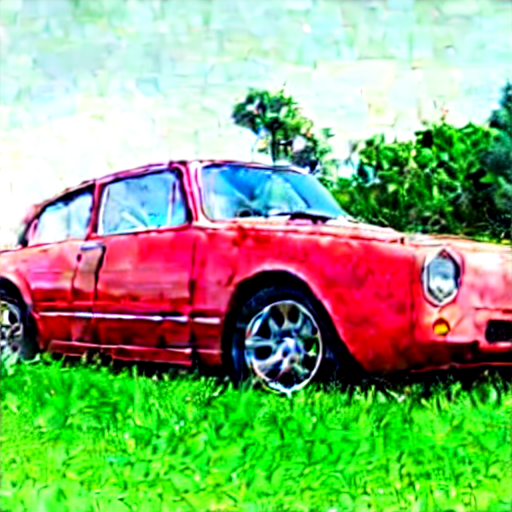

In [22]:
self.set_scheduler(scheduler_type="ldm")

prompt_trans = "A photo of a car "
z0_new = self.diffusion_loop(
        prompt=prompt_trans,
        latents=latent_samples,
        start_step=1,
        seed=None,
        num_inference_steps=10,
        guidance_scale=7.5)
x0_new = self.decode(z0_new)
image_grid(x0_new)

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()
n = 10
num_rows = 4
num_col = n // num_rows
num_col  = num_col + 1 if n % num_rows else num_col
num_col

3